# ML for UK

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import pickle

pd.set_option("display.max_columns", None)
uk_processed_dir = "../data/uk/processed/"


In [ ]:
seasons = {
             0: 'winter',
             1: 'spring',
             2: 'summer',
             3: 'autumn'
}

In [70]:
target_column = 'power'
feature_columns = ['wind_speed', 'season_0', 'season_1', 'season_2', 'season_3', 'wind_direction', 'ambient_temperature']

In [71]:
train_data = pd.read_csv(f'{uk_processed_dir}full_train.csv', index_col=0)
train_data.index = pd.to_datetime(train_data.index)

test_data = pd.read_csv(f'{uk_processed_dir}full_test.csv', index_col=0)
test_data.index = pd.to_datetime(test_data.index)


In [72]:
# season: 0 = winter (dec, jan, feb), 1 = spring (mar, apr, may), 2 = summer (jun, jul, aug), 3 = autumn (sep, oct, nov) for uk only!
# train_data["month"] = train_data.index.month
train_data["season"] = train_data.index.month % 12 // 3
# one hot encode season column using values 0 and 1
train_data = pd.get_dummies(train_data, columns=['season'])

# test_data["month"] = test_data.index.month
test_data["season"] = test_data.index.month % 12 // 3
test_data = pd.get_dummies(test_data, columns=['season'])

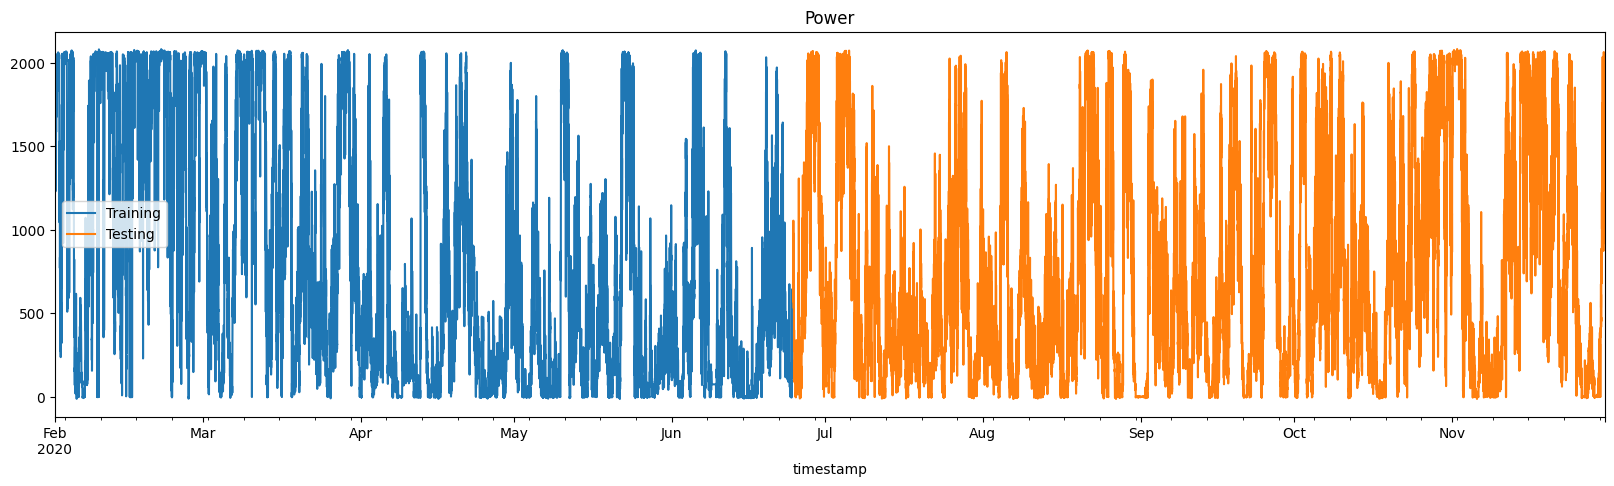

In [19]:
period = slice('02-2020', '11-2020')
figure, ax = plt.subplots(figsize=(20, 5))
train_data[period].plot(ax=ax, label="Training", y="power")
test_data[period].plot(ax=ax, label="Testing",  y="power", title="Power")
plt.show()

In [54]:
train_data['12-2018':]

,wind_speed,power,ambient_temperature,long_term_wind,wind_direction,season_0,season_1,season_2,season_3
timestamp,,,,,,,,,
2018-12-01 00:00:00,6.896830,881.977356,9.935000,7.0,215.367874,True,False,False,False
2018-12-01 00:10:00,7.372150,950.215271,9.855000,7.0,214.052124,True,False,False,False
2018-12-01 00:20:00,7.639380,830.064026,9.632500,7.0,212.998718,True,False,False,False
2018-12-01 00:30:00,7.422464,793.701538,9.600000,7.0,214.681183,True,False,False,False
2018-12-01 00:40:00,7.037760,781.627747,9.465000,7.0,208.303146,True,False,False,False
...,...,...,...,...,...,...,...,...,...
2020-06-24 18:10:00,5.911384,397.276057,33.537501,5.3,117.297853,False,False,True,False
2020-06-24 18:20:00,5.956008,527.838094,33.164999,5.3,113.148684,False,False,True,False
2020-06-24 18:30:00,6.387883,464.681625,32.612500,5.3,114.189266,False,False,True,False


In [73]:
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

In [7]:
# train_data before moving shift to data_preprocessor

,wind_speed,power,ambient_temperature,long_term_wind,wind_direction,month,quarter
timestamp,,,,,,,
2016-06-01 00:00:00,9.087127,1424.596924,14.175000,5.3,5.273296,6,2
2016-06-01 00:10:00,9.572797,1661.680054,13.972500,5.3,2.064881,6,2
2016-06-01 00:20:00,9.937403,1799.087524,14.125000,5.3,0.553815,6,2
2016-06-01 00:30:00,10.572899,1817.044556,13.850000,5.3,0.447842,6,2
2016-06-01 00:40:00,10.191404,1774.994019,14.085000,5.3,359.351379,6,2
...,...,...,...,...,...,...,...
2020-06-24 18:20:00,5.956008,397.276057,33.164999,5.3,113.148684,6,2
2020-06-24 18:30:00,6.387883,527.838094,32.612500,5.3,114.189266,6,2
2020-06-24 18:40:00,6.467776,464.681625,32.550000,5.3,117.290150,6,2


In [21]:
train_data

,wind_speed,power,ambient_temperature,long_term_wind,wind_direction,hour,day,month,quarter
timestamp,,,,,,,,,
2016-06-01 00:00:00,9.087127,1661.680054,14.175000,5.3,5.273296,0,1,6,2
2016-06-01 00:10:00,9.572797,1799.087524,13.972500,5.3,2.064881,0,1,6,2
2016-06-01 00:20:00,9.937403,1817.044556,14.125000,5.3,0.553815,0,1,6,2
2016-06-01 00:30:00,10.572899,1774.994019,13.850000,5.3,0.447842,0,1,6,2
2016-06-01 00:40:00,10.191404,1840.554443,14.085000,5.3,359.351379,0,1,6,2
...,...,...,...,...,...,...,...,...,...
2020-06-24 18:10:00,5.911384,397.276057,33.537501,5.3,117.297853,18,24,6,2
2020-06-24 18:20:00,5.956008,527.838094,33.164999,5.3,113.148684,18,24,6,2
2020-06-24 18:30:00,6.387883,464.681625,32.612500,5.3,114.189266,18,24,6,2


In [11]:
# train_df = X_train[:-1].copy()
# train_df["power"] = y_train[1:]
# train_df

,wind_speed,month,quarter,power
timestamp,,,,
2016-06-01 00:00:00,9.087127,6,2,NaN
2016-06-01 00:10:00,9.572797,6,2,1661.680054
2016-06-01 00:20:00,9.937403,6,2,1799.087524
2016-06-01 00:30:00,10.572899,6,2,1817.044556
2016-06-01 00:40:00,10.191404,6,2,1774.994019
...,...,...,...,...
2020-06-24 18:10:00,5.911384,6,2,339.743454
2020-06-24 18:20:00,5.956008,6,2,397.276057
2020-06-24 18:30:00,6.387883,6,2,527.838094


In [84]:
# XGBoost 10min
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = xgb.XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [28]:
# XGBoost 6*10min
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
oneh_model = xgb.XGBRegressor()
parameters = {
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 500],
    "colsample_bytree": [0.5]
}


oneh_grid_search = GridSearchCV(estimator=oneh_model, cv=cv_split, param_grid=parameters)
oneh_grid_search.fit(X_train[:-6], y_train[6:])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, impo...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.5],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 500]})

In [59]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

def save_model(model, filename):
  pickle.dump(model, open(filename, 'wb'))
  print(f"Model saved as {filename}")

In [76]:
# Save model
save_model(grid_search, "./models/uk_xgb_10min.pkl")

Model saved as ./models/uk_xgb_10min.pkl


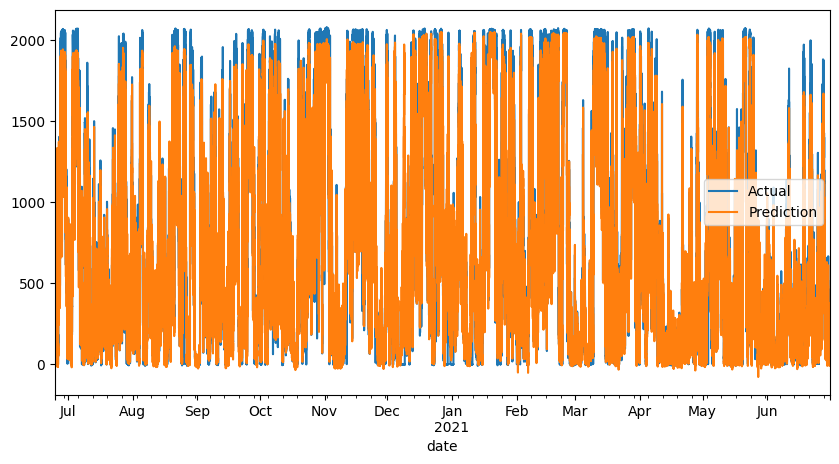

MAE: 120.11543716745223
RMSE: 198.09739127872896


In [67]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(test_data.index, y_test, prediction)
evaluate_model(y_test, prediction)

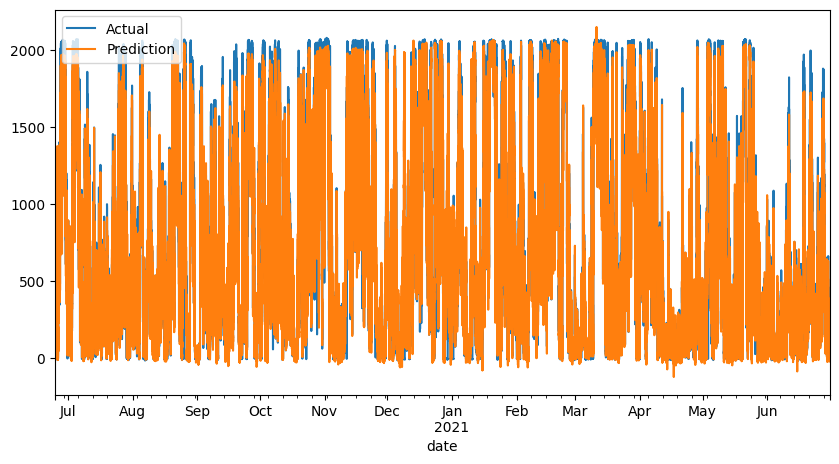

MAE: 117.178509013345
RMSE: 196.33446984667717


In [75]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(test_data.index, y_test, prediction)
evaluate_model(y_test, prediction)

In [ ]:
# Evaluating GridSearch results
prediction = oneh_grid_search.predict(X_test[:-6])
plot_predictions(test_data.index[:-6], y_test[6:], prediction)
evaluate_model(y_test[6:], prediction)

In [14]:
xgb.plot_tree(grid_search.best_estimator_, num_trees=14)
fig = plt.gcf()
fig.set_size_inches(150, 100)
# fig.savefig('tree_20.png')

In [83]:
grid_search.best_estimator_.n_estimators

500

[0.7284608  0.04858681 0.03142034 0.10543337 0.00938964 0.05860683
 0.0181023 ]
['wind_speed', 'season_0', 'season_1', 'season_2', 'season_3', 'wind_direction', 'ambient_temperature']


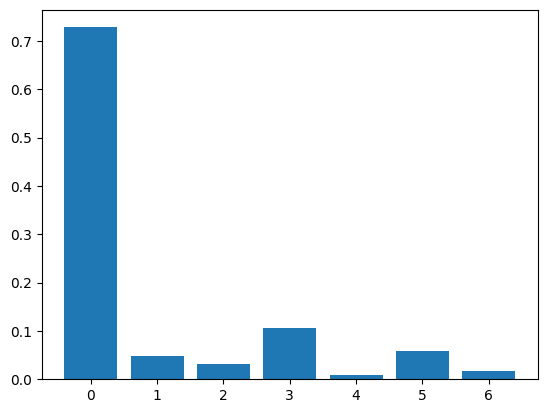

In [81]:
print(grid_search.best_estimator_.feature_importances_)
print(feature_columns)
plt.bar(range(len(grid_search.best_estimator_.feature_importances_)), grid_search.best_estimator_.feature_importances_)
plt.show()

In [36]:
train_data_shifted = train_data.copy()
train_data_shifted["power"] = train_data_shifted["power"].shift(-1)
train_data_shifted

,wind_speed,power,ambient_temperature,long_term_wind,wind_direction,month,quarter
timestamp,,,,,,,
2016-06-01 00:00:00,9.087127,1661.680054,14.175000,5.3,5.273296,6,2
2016-06-01 00:10:00,9.572797,1799.087524,13.972500,5.3,2.064881,6,2
2016-06-01 00:20:00,9.937403,1817.044556,14.125000,5.3,0.553815,6,2
2016-06-01 00:30:00,10.572899,1774.994019,13.850000,5.3,0.447842,6,2
2016-06-01 00:40:00,10.191404,1840.554443,14.085000,5.3,359.351379,6,2
...,...,...,...,...,...,...,...
2020-06-24 18:20:00,5.956008,527.838094,33.164999,5.3,113.148684,6,2
2020-06-24 18:30:00,6.387883,464.681625,32.612500,5.3,114.189266,6,2
2020-06-24 18:40:00,6.467776,435.347701,32.550000,5.3,117.290150,6,2
